Explained variance ratio (PCA): [0.54831944 0.13875918 0.11128158 0.07999807 0.05308164]
Total explained variance by first 5 components: 0.9314399274960985


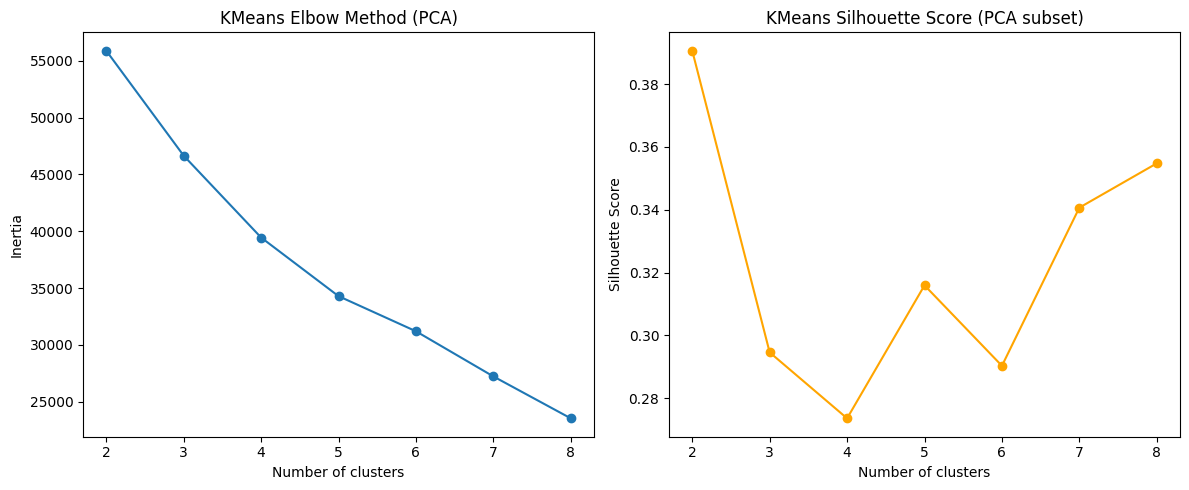

KMeans cluster counts:
KMeans_Cluster
0    217621
1    204094
Name: count, dtype: int64
Silhouette Score (full PCA data, K=2): 0.3949


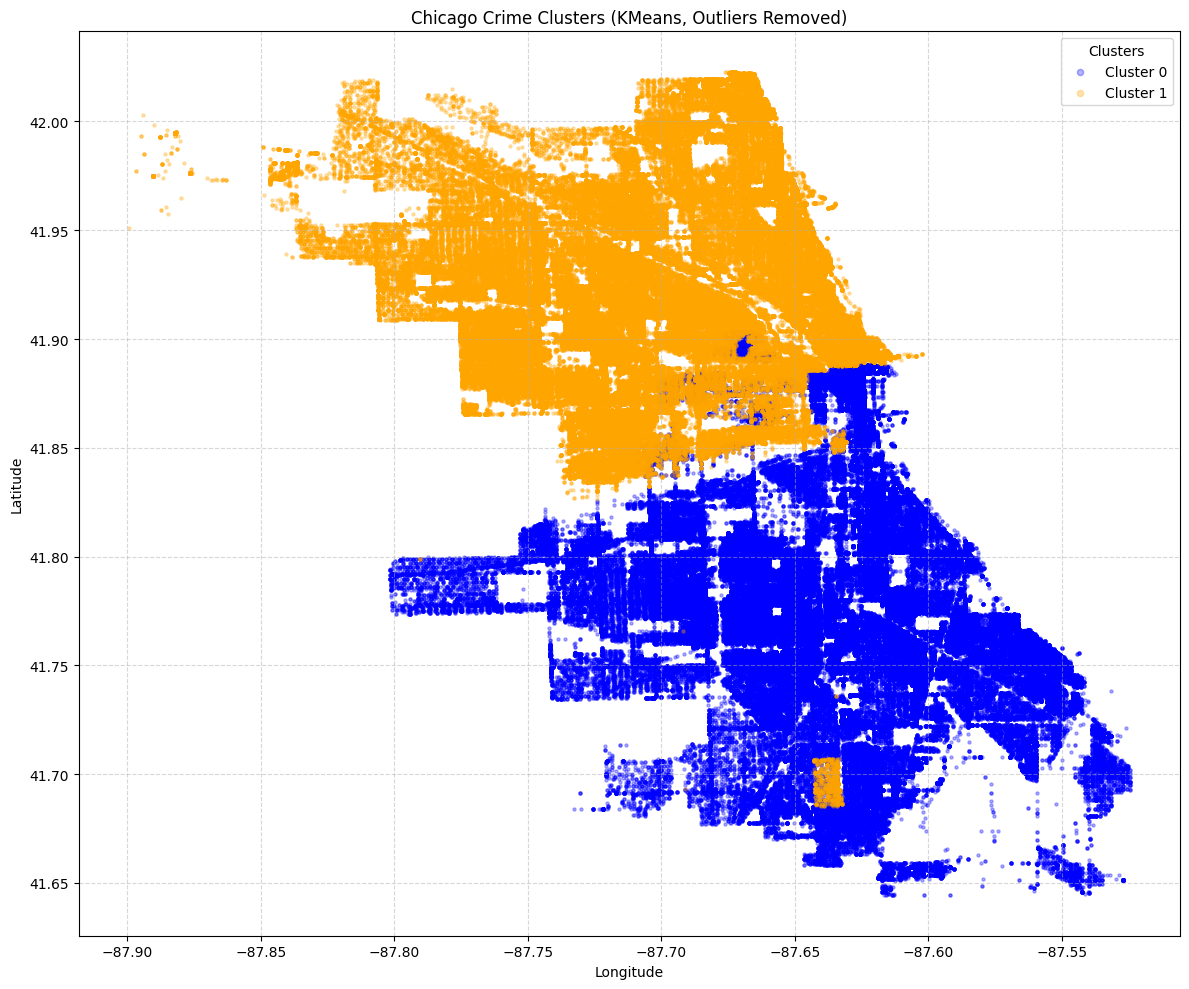

                  Arrest  Domestic      Beat  District      Ward  \
KMeans_Cluster                                                     
0               0.210931  0.202205 -0.682382 -0.710717 -0.675720   
1               0.220585  0.147775  0.727609  0.757822  0.720506   

                Community Area      Year  Latitude  Longitude  Latitude_raw  \
KMeans_Cluster                                                                
0                     0.739700 -0.028969 -0.794093   0.558387     41.775320   
1                    -0.788726  0.030889  0.846724  -0.595396     41.917838   

                ...  Location Description_VEHICLE - COMMERCIAL: TROLLEY BUS  \
KMeans_Cluster  ...                                                           
0               ...                                            0.00000        
1               ...                                            0.00001        

                Location Description_VEHICLE - DELIVERY TRUCK  \
KMeans_Cluster              

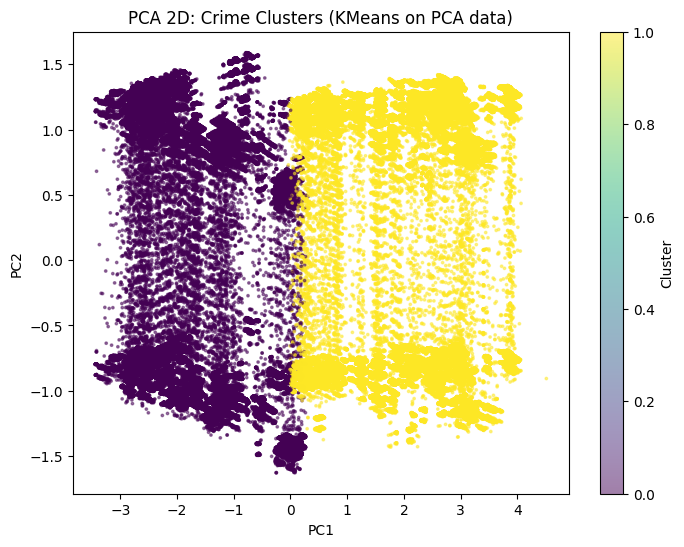

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1. PREPROCESSING AND SETUP
data = pd.read_csv("E:\\SEM-2\\AI&ML\\chicagao excel dataset reduced 1.csv")

columns_to_drop = [
    'ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Description',
    'Updated On', 'Location', 'X Coordinate', 'Y Coordinate'
]
data = data.drop(columns=columns_to_drop, errors='ignore')
data = data.fillna(data.mode().iloc[0])

# --------- OUTLIER REMOVAL BASED ON LATITUDE AND LONGITUDE ---------
lat_min, lat_max = 41.6, 42.1
long_min, long_max = -87.9, -87.5

if 'Latitude' in data.columns and 'Longitude' in data.columns:
    mask = (
        (data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) &
        (data['Longitude'] >= long_min) & (data['Longitude'] <= long_max)
    )
    data = data[mask].copy()

# Save raw coordinates for plotting BEFORE scaling
data['Latitude_raw'] = data['Latitude']
data['Longitude_raw'] = data['Longitude']

categorical_cols = ['Primary Type', 'Location Description']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

for col in ['Arrest', 'Domestic']:
    if col in data.columns:
        data[col] = data[col].astype(int)

numeric_cols = ['Beat', 'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Prepare numeric data for PCA and clustering
df_numeric = data.select_dtypes(include=[np.number]).fillna(data.mean(numeric_only=True))

# PCA BEFORE CLUSTERING
n_pca_components = 5
pca = PCA(n_components=n_pca_components)
df_pca = pca.fit_transform(df_numeric)
print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)
print("Total explained variance by first", n_pca_components, "components:", np.sum(pca.explained_variance_ratio_))

# SUBSET FOR ELBOW & SILHOUETTE (on PCA data)
sample_size = 15000
if len(df_pca) > sample_size:
    idx = np.random.choice(len(df_pca), sample_size, replace=False)
    X_sample = df_pca[idx]
else:
    X_sample = df_pca

# ELBOW AND SILHOUETTE PLOTS
inertias = []
sil_scores = []
K = range(2, 9)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_sample, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.title("KMeans Elbow Method (PCA)")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.title("KMeans Silhouette Score (PCA subset)")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

# FINAL KMEANS ON PCA DATA
optimal_k = 2 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['KMeans_Cluster'] = kmeans.fit_predict(df_pca)
print("KMeans cluster counts:")
print(data['KMeans_Cluster'].value_counts())

# Silhouette score for final clustering on ALL (PCA) data
full_silhouette = silhouette_score(df_pca, data['KMeans_Cluster'])
print(f"Silhouette Score (full PCA data, K={optimal_k}): {full_silhouette:.4f}")

# MAP VISUALIZATION (use raw coordinates)
plt.figure(figsize=(12,10))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
for idx, k in enumerate(sorted(data['KMeans_Cluster'].unique())):
    subset = data[data['KMeans_Cluster'] == k]
    plt.scatter(subset['Longitude_raw'], subset['Latitude_raw'],
                label=f"Cluster {k}", alpha=0.3, s=5, c=colors[idx % len(colors)])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title="Clusters", loc='best', markerscale=2)
plt.title("Chicago Crime Clusters (KMeans, Outliers Removed)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# CLUSTER PROFILING
print(data.groupby('KMeans_Cluster').mean(numeric_only=True))
for k in sorted(data['KMeans_Cluster'].unique()):
    print(f"\n--- Cluster {k} ---")
    if 'Primary Type' in data.columns:
        print(data[data['KMeans_Cluster'] == k]['Primary Type'].value_counts().head(5))
    print("Arrest Rate:", data[data['KMeans_Cluster'] == k]['Arrest'].mean())

# PCA COMPONENT VISUALIZATION (2D)
pca2 = PCA(n_components=2)
df_pca2 = pca2.fit_transform(df_numeric)
plt.figure(figsize=(8,6))
plt.scatter(df_pca2[:,0], df_pca2[:,1], c=data['KMeans_Cluster'], cmap='viridis', alpha=0.5, s=3)
plt.title("PCA 2D: Crime Clusters (KMeans on PCA data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()